# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

import oscillator
import oscillator_analysis

/home/ddallo/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 53 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000007
[3]:  Bus 1 Device 31 Dynapse1DevKit serial_number 00000020
[4]:  Bus 1 Device 25 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [164]:
chip = 2
core_e1 = 0
core_e2 = 1
core_i = 2

duration = 2

size_E = 4
size_I = size_E // 4
neuron_pool = np.random.choice(np.arange(1,256), 2*(size_E+size_I), False)

neuron_ids_E1 = neuron_pool[:size_E]
neuron_ids_E2 = neuron_pool[size_E:2*size_E]
neuron_ids_I1 = neuron_pool[-2*size_I:-size_I]
neuron_ids_I2 = neuron_pool[-size_I:]

# init a network generator
net = network.DynapseNetworkGenerator()

neurons_E1 = net.get_neurons(chip, core_e1, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e2, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)

net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=4)

net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=4)
# coupling
net.add_connections_all_to_all(neurons_I1, neurons_I2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2, neurons_I1, network.SYNAPSE_GABA_B)

dynapse.monitor_neuron_network(neurons_E1, neurons_E2, neurons_I1, neurons_I2)

model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [165]:
# set params
parameters.set_all_default_params(model)

# try to get each oscillator at 2 Hz
parameters.set_param(model, parameters.AMPA_WEIGHT, (6,40), chip, core_e1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e1)

parameters.set_param(model, parameters.AMPA_WEIGHT, (6,40), chip, core_e2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e2)

parameters.set_param(model, parameters.AMPA_WEIGHT, (5,100), chip, core_i)

parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_i)
parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,80), chip, core_i)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_i)

2400000000.0

In [57]:
import importlib
importlib.reload(oscillator)

osc = oscillator.get_random_oscillator(dynapse, 16, 1, [0,2])
osc.start()

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [58]:
dynapse.start_graph()

In [63]:
parameters.set_all_default_params(model)
osc.set_default_params()
osc.set_E_DC_input(2,60)
osc.set_I_AMPA(5,150)

* to increase e1 firing rate, increase core_e1 DC input
* if e1 fires periodically but doesn't burst - increase e1 AMPA weight
* Same for e2


* decrease core_i AMPA weight to increase burst width, and increase it if the inhibitory neurons aren't spiking
* increasing the pulse width decreases the firing rate of the oscillator - can increase DC input to compensate...


* sometimes takes a while for it to settle into antiphase
* pulse width can be brittle with low values - reducing fine value by one can cause a big jump - here it's better to use a pulse width slightly above half

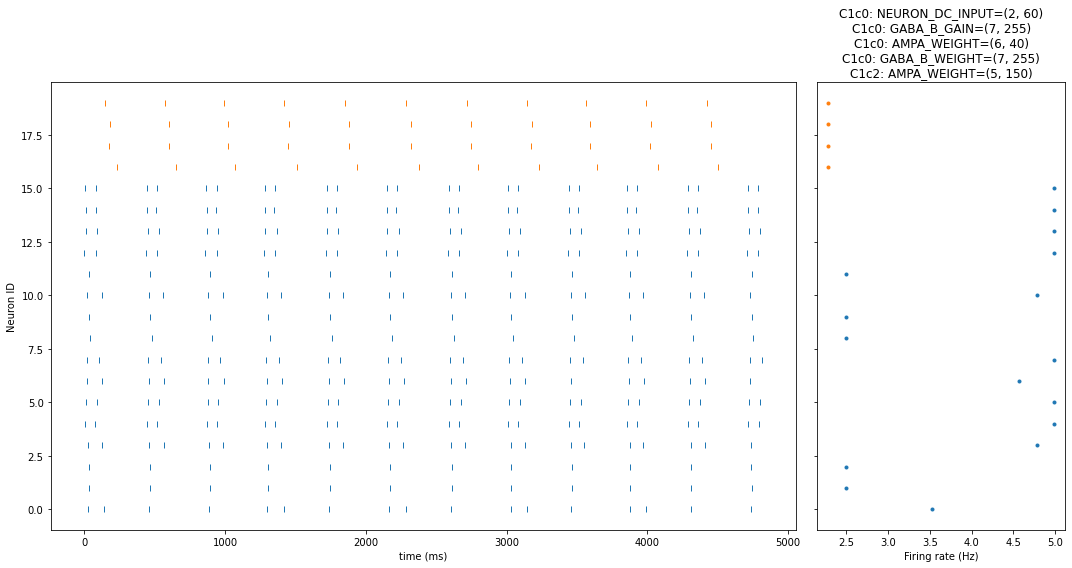

f = 2.339318 Hz


In [64]:
spikes = dynapse.run_simulation(5)

plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,8))

frequency = oscillator_analysis.get_oscillator_frequency(spikes, dynapse.monitored_neuron_groups[1])
print(f'f = {frequency:4f} Hz')
# frequency_and_phase = oscillator_analysis.get_coupled_oscillator_frequency_phase(spikes, dynapse.monitored_neuron_groups[2], dynapse.monitored_neuron_groups[3])
# print('I1: = %.4f Hz, I2: %.4f Hz, phase: %.2f deg' % frequency_and_phase)

### Testing for weird memory bug

In [115]:
default_param_map = parameters.get_default_params().param_map
config = model.get_configuration()

for chip in range(4):
		for core in range(4):
			for param_name, param in config.chips[chip].cores[core].parameter_group.param_map.items():
				if default_param_map[param_name].coarse_value != param.coarse_value or default_param_map[param_name].fine_value != param.fine_value:
					print(f'{param_name}: {(param.coarse_value,param.fine_value)} vs. {(default_param_map[param_name].coarse_value,default_param_map[param_name].fine_value)}')

NPDPII_THR_S_P: (7, 80) vs. (4, 80)
PS_WEIGHT_EXC_F_N: (5, 40) vs. (0, 0)
PS_WEIGHT_EXC_S_N: (5, 50) vs. (0, 0)
PS_WEIGHT_INH_S_N: (7, 200) vs. (0, 0)
PS_WEIGHT_EXC_F_N: (5, 30) vs. (0, 0)
PS_WEIGHT_INH_S_N: (6, 80) vs. (0, 0)
